In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
from dask_gateway import Gateway
from dask.distributed import Client
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt()
client = Client(cluster)
cluster

# # this block starts clusters we will need for fast parallel? calculations
# from dask_gateway import Gateway
# from dask.distributed import Client
# gateway = Gateway()
# cluster = gateway.new_cluster()
# cluster.adapt(minimum=2, maximum=20)
# client = Client(cluster)
# cluster

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import os.path
import xesmf as xe
from scipy.signal import detrend
import math

In [4]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#         print(model, var, "found data")
    except:
        ds = []
        #print(model, var, "no data")
    return ds        

In [5]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# models = ['CESM2', 'GFDL-CM4', 'GFDL-ESM4', 'CESM2-WACCM', 'IPSL-CM6A-LR', 'MRI-ESM2-0',
#           'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'UKESM1-0-LL',  'CanESM5', 'NorESM2-LM', 
#           'MPI-ESM1-2-HR', 'NorCPM1', 'MIROC-ES2L', 'CNRM-ESM2-1']
# models with ssp585 experiment
# models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
#           'MRI-ESM2-0','NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
#           'MPI-ESM1-2-HR','MPI-ESM1-2-LR', 'EC-Earth3']
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L'
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']

In [6]:
# Another method for out grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

In [7]:
def parse_vals(string, start, end, delimiter):
    
    if type(string) == str:
        
        while string.find(start) != -1:
            temp_index = string.find(start)
            string = string[temp_index+1:]
        try:
            string = string[:string.find(end)]
        except:
            string = "ending occurs before last start instance"
        
        temp_list = list(string.split(delimiter))
        
        list_len = len(temp_list)
        for i in range(list_len):
            
            temp_list[i] = temp_list[i].strip(' \t\n\r')

        try:
            return_val = list(map(float,temp_list))
        except: 
            return_val = ["not integers"]
        
    else:
        return_val = ["invalid string"]
        
        
    return np.array(return_val)

In [8]:
expe = 'historical'
freq = 'Omon'
start_year = '1991'
end_year = '2010'

# expe = 'ssp585'
# freq = 'Omon'
# start_year = '2081'
# end_year = '2100'

var = 'zooc'
model = 'MPI-ESM1-2-HR'
vvar = var + 'os'
xray = get_data(df, vvar, model, expe, freq)
print(xray)
print('xray above')
if isinstance(xray, xr.Dataset):
        xxray_in = xray
        print('was')
else:
        vvar = var    
        xray = get_data(df, vvar, model, expe, freq)
        xxray_in= xray

[]
xray above


In [9]:
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L'
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']
# models = ['CESM2-WACCM']
#models=['NorESM2-LM']
# models = ['CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']
# models = ['CESM2-WACCM', 'GFDL-CM4']
# var_names=['phyc','chl','phydiat','zooc','tos']
# var_names = ['phyc', 'chl', 'phydiat', 'zooc','intpp','epc100','fgco2','spco2','dfe','no3','si','tos','omldamax','hfds','rsntds']
var_names = ['phyc']
#
expe = 'historical'
freq = 'Omon'
start_year = '1991'
end_year = '2010'
diff = 2014-1995+1

# expe = 'ssp585'
# freq = 'Omon'
# start_year = '2081'
# end_year = '2100'
# diff = 2100-2081+1

# n_slice_low = 45
# n_slice_high = 60

# n_slice_low = 60
# n_slice_high = 90

n_slice_low_list = [60,50,40,10,-10,-40,-50,-60,-90]
n_slice_high_list = [90,60,50,40,10,-10,-40,-50,-60]
length = len(n_slice_high_list)

# length = 1

#new_models = ['GISS-E2-1-G', 'GISS-E2-1-G-CC']
# new_vars = ['phydiat']   # new models aren't working here. 
xxray_in = []
# true_var = 'phydiat'
for model in models:
    print(model)
    for var in var_names:
        vvar = var + 'os'
        xray = get_data(df, vvar, model, expe, freq)
        if isinstance(xray, xr.Dataset):
            xxray_in = xray
            
        else:
            vvar = var    
            xray = get_data(df, vvar, model, expe, freq)
            xxray_in= xray
            
        if ((model == 'MPI-ESM1-2-HR' and (var == 'zooc' or var == 'si')) or
            (model == 'MRI-ESM2-0' and var == 'chl') or
            (model == 'UKESM1-0-LL' and (var == 'phydiat' or var == 'chl' or var == 'zooc')) or
            (model == 'CNRM-ESM2-1' and (var == 'dfe' or var == 'zooc'))):
            print('wont work')
        else:
#             print("so far good")
            if isinstance(xxray_in, xr.Dataset):
#                     print("instance")
                    
                    ds = xxray_in.sel(time=slice(start_year, end_year))[vvar]

                    if 'latitude' in ds.coords:
                        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
                    if 'nav_lat' in ds.coords:
                        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

                    if 'lev_partial' in ds.coords:
                        ds = ds.isel(lev_partial=0)
                    if 'olevel' in ds.coords:
                        ds = ds.isel(olevel=0)
                    if 'lev' in ds.coords:
                        ds = ds.isel(lev=0)

                    if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                        if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
                            ds = ds.where(ds>=0)

                    dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
                    dsr._grid_in = None
                    dsr._grid_out = None
                    dsr_out0 = dsr(ds)
                    dsr_out = xr.Dataset({var:dsr_out0})

#                     print(dsr_out[var].shape[0])
                    if dsr_out[var].shape[0]==12*diff: #5 years 12 months
                        print(var)
                        #north pacific only
#                         ds_np = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(210,220)) #45 north, 210 east
#                         dsm_np = ds_np[var].mean(dim='time',skipna=1)
#                         anom_np = ds_np[var] - dsm_np
#                         anom_np.load()
#     #                     anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0), anom_np.chunk({"lon":45,"lat":45}), kwargs={'axis': 0}).where(~anom_np.isnull())
#                         anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0).chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anom_np.dtype]).where(~anom_np.isnull())
#                         detrend_np = anom_detrended_np + dsm_np
#                         do_np = detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values

#redundant do not uncomment
#                         if var == 'spco2':
#                             do_np = do_np / 0.101325
#                         if var == 'phyc' or var == 'phycos':
#                             do_np = do_np * 12000 # more info
#                         if var == 'phycdiat'or var == 'phycdiatos':
#                             do_np = do_np * 12000 # more info
#                         if var == 'fgco2':
#                             do_np = do_np * 3600 * 24 * 365 * 1000 / (44/12) 

#                         savef_np = '/home/jovyan/tempfolder/' + model + '_' + var + '_np.txt'
#                         with open(savef_np, 'w') as npf:
#                             for idata in do_np:
#                                 npf.write(str(idata) +"\n")

#                         print("forloop") 

                        for i in range(0,length):
#                             print("loop run" + str(i+1))
                            n_slice_low = n_slice_low_list[i]
                            n_slice_high = n_slice_high_list[i]
                            ofn = '/home/jovyan/tempfolder/' + model + '_' + var + '_' + str(n_slice_low) + '_' + str(n_slice_high) + '_ln_histogram' + '_np.txt'

                            if(os.path.exists(ofn)):
                                print('already calculated')
                            else:
                                print('calculating')
                                ds_np = dsr_out.sel(lat=slice(n_slice_low,n_slice_high)).sel(lon=slice(140,240))
#                                 ds_added = dsr_out.sel(lat=slice(n_slice_low,n_slice_high)).sel(lon=slice(0,20))

    #                             print(ds_na)
#                                 ds_na = xr.merge([ds_na,ds_added])


                                dsm_np = ds_np[var].mean(dim='time', skipna=1)
                                anom_np = ds_np[var] - dsm_np
                                anom_np.load()
                                anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0),kwargs={'axis': 0}, dask="parallelized", output_dtypes=[anom_np.dtype]).where(~anom_np.isnull())
                                detrend_np = anom_detrended_np + dsm_np
                                do_np = detrend_np.groupby('time.month').mean('time',skipna=1).values
                                if var == 'spco2':
                                    do_np = do_np / 0.101325
        #                         if var == 'phyc' or var == 'phycos':
        #                             do_na = do_na * 12000 # more info
        #                         if var == 'phycdiat'or var == 'phycdiatos':
        #                             do_na = do_na * 12000 # more info
                                if var == 'fgco2':
                                    do_np = do_np * 3600 * 24 * 365 * 1000 / (44/12) 
                                hdata = []
                                for x in range(len(do_np)):
                                    for y in range(len(do_np[0])):
                                        for z in range(len(do_np[0][0])):
                                            if (do_np[x][y][z] == do_np[x][y][z] and do_np[x][y][z] > 0):
                                                hdata.append(math.log(12000*do_np[x][y][z]))
                                savef_np = '/home/jovyan/tempfolder/' + model + '_' + var + '_' + str(n_slice_low) + '_' + str(n_slice_high) + '_ln_histogram' + '_np.txt'
                                with open(savef_np, 'w') as npf:
                                    for idata in hdata:
                                        npf.write(str(idata) +"\n")

                        for i in range(0,length):
#                             print("loop run" + str(i+1))
                            n_slice_low = n_slice_low_list[i]
                            n_slice_high = n_slice_high_list[i]
                            ofn = '/home/jovyan/tempfolder/' + model + '_' + var + '_' + str(n_slice_low) + '_' + str(n_slice_high) + '_ln_histogram' + '_na.txt'

                            if(os.path.exists(ofn)):
                                print('already calculated')
                            else:
                                print('calculating')
                                ds_na = dsr_out.sel(lat=slice(n_slice_low,n_slice_high)).sel(lon=slice(290,360))
                                ds_added = dsr_out.sel(lat=slice(n_slice_low,n_slice_high)).sel(lon=slice(0,20))

    #                             print(ds_na)
                                ds_na = xr.merge([ds_na,ds_added])


                                dsm_na = ds_na[var].mean(dim='time', skipna=1)
                                anom_na = ds_na[var] - dsm_na
                                anom_na.load()
                                anom_detrended_na = xr.apply_ufunc(detrend, anom_na.fillna(0),kwargs={'axis': 0}, dask="parallelized", output_dtypes=[anom_na.dtype]).where(~anom_na.isnull())
                                detrend_na = anom_detrended_na + dsm_na
                                do_na = detrend_na.groupby('time.month').mean('time',skipna=1).values
                                if var == 'spco2':
                                    do_na = do_na / 0.101325
        #                         if var == 'phyc' or var == 'phycos':
        #                             do_na = do_na * 12000 # more info
        #                         if var == 'phycdiat'or var == 'phycdiatos':
        #                             do_na = do_na * 12000 # more info
                                if var == 'fgco2':
                                    do_na = do_na * 3600 * 24 * 365 * 1000 / (44/12) 
                                hdata = []
                                for x in range(len(do_na)):
                                    for y in range(len(do_na[0])):
                                        for z in range(len(do_na[0][0])):
                                            if (do_na[x][y][z] == do_na[x][y][z] and do_na[x][y][z] > 0):
                                                hdata.append(math.log(12000*do_na[x][y][z]))
                                savef_na = '/home/jovyan/tempfolder/' + model + '_' + var + '_' + str(n_slice_low) + '_' + str(n_slice_high) + '_ln_histogram' + '_na.txt'
                                with open(savef_na, 'w') as naf:
                                    for idata in hdata:
                                        naf.write(str(idata) +"\n")

#                 dsr.clean_weight_file()
                
#                 :~$ tar -czvf NA_NPssp585.tar.gz save

CESM2-WACCM
phyc
calculating
calculating
calculating
calculating
calculating
calculating
calculating
calculating
calculating
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
CESM2
phyc
calculating
calculating
calculating
calculating
calculating
calculating
calculating
calculating
calculating
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
GFDL-CM4
phyc
calculating
calculating
calculating
calculating
calculating
calculating
calculating
calculating
calculating
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
already calculated
GFDL-ESM4
phyc
calculating
calculating
calculating
calculating
calculating
calculating
calculating
calculating
calculatin

In [10]:
# ofn = '/home/jovyan/tempfolder/' + 'CESM2-WACCM' + '_' + 'phyc' + '_' + '60' + '_' + '90' + '_histogram' + '_na.txt'
# if(os.path.exists(ofn)):
#     print('already calculated')
#     dm=[]
#     with open(ofn, "r") as rf:
#         for line in rf:
#             dm.append(float(line.strip()))

#     xmon = np.arange(1, 13)
#     s = np.array(dm)
# plt.hist(s)

In [11]:
Time_months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec');
# start_year = 1995
# end_year = 2014
# var_names=['phyc','chl','phydiat','zooc','intpp','epc100',
#            'fgco2','spco2','dfe','no3','si','rsntds']

# var_names = ['tos','phyc','zooc']
var_names=['phyc']
           
# models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
#           'MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
#           'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
#           'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']

models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L',
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']

# models = ['CESM2',  'GFDL-ESM4', 'ACCESS-ESM1-5', 'CESM2-WACCM','IPSL-CM6A-LR', 
#           'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'CanESM5', 'NorESM2-LM',
#           'MPI-ESM1-2-HR', 'NorCPM1', 'MIROC-ES2L', 'CNRM-ESM2-1']
# 
# models = ['CESM2-WACCM','GFDL-CM4']

# plot_titles=['Biomass (mgC/m3)','Chlorophyll (kg/m3)','Diatom (mgC/m3)', 
#              'Zooplankton (mgC/m3)','Primary Production (mgC/m2/s)','Export Production at 100m (mol/m2/s)',
#              'Air-sea CO2 flux (donward +) (gram C /m2/year)','SpCO2 (ppm)', 'Iron - Fe (mol/m3)', 
#              'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Light - Surface Downward SW Radiation (W/m2)']

plot_titles = ['60N-90N; 70W-20E','50N-60N; 70W-20E','40N-50N; 70W-20E','10N-40N; 70W-20E','-10S-10N; 70W-20E','40S-10S; 70W-20E','50S-40S; 70W-20E',
              '60S-50S; 70W-20E','90S-60S; 70W-20E']



# plot_ranges=[[-0.001,0.0175], [-0.1e-6,3e-6], [-0.0005, 0.010], [-0.0005,0.008], 
plot_ranges=[[-0.001,200], [-0.1e-6,4.2e-6], [-0.0005, 200], [-0.0005,100],              
             [-0.05e-6,20e-3], [-0.1e-7,3e-7], [-60,85], [100, 500],  
             [-0.1e-7,2e-6], [-0.001,0.02], [-0.001,0.012], [0,300]]
colors = [[255, 255, 38], [255, 255, 38], [255,209, 35],
          [255, 157, 9], [255, 2, 2], [255, 148, 255],
          [255, 6, 255], [127, 245, 206], [26, 136, 255],
          [26, 136, 255], [17, 137, 17], [17, 137, 17],
          [8, 8, 126], [130, 55, 6], [112, 48, 160],
          [92, 92, 255], [92, 92, 255], [4, 2, 0]]
newcolors = []
for color in colors:
    newcolors.append([x/255.0 for x in color])
colors=newcolors

print(var_names)

['phyc']


In [12]:
# model = 'CESM2-WACCM'
# var = 'phyc'
# n_slice_low = 60
# n_slice_high = 90

# ofn = '/home/jovyan/tempfolder/' + model + '_' + var + '_' + str(n_slice_low) + '_' + str(n_slice_high) + '_histogram' + '_na.txt'

# if(os.path.exists(ofn)):
#     print('already calculated')
#     dm=[]
#     with open(ofn, "r") as rf:
#         for line in rf:
#             dm.append(parse_vals(line, '[', ']', ','))
#     print(dm)
#  ## DONE in regridding
#     if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
#         if var == 'chl':
#             s = s * 0.001        # need more infromation, why???
#     if var == 'phyc' or var=='phycos':
#         s = s * 12000 # 
#     if var == 'phydiat' or var == 'phydiatos':
#         s = s * 12000 # 
#     if var == 'zooc' or var == 'zoocos':
#         s = s * 12000 # 
#     if var == 'intpp': 
#         s = s * 12000 #
#     if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
#         if var == 'intpp':
#             s = -s             # need more infromation
#         if var == 'fgco2':
#             s = s*(10**(-10))    # need more infromation
#         if var == 'dfe':
#             xmon =[]
#             s = []        # need more infromation
    


phyc
0
1
2
3
4
5
6
7
8
CPU times: user 3.14 s, sys: 91.3 ms, total: 3.23 s
Wall time: 5.46 s


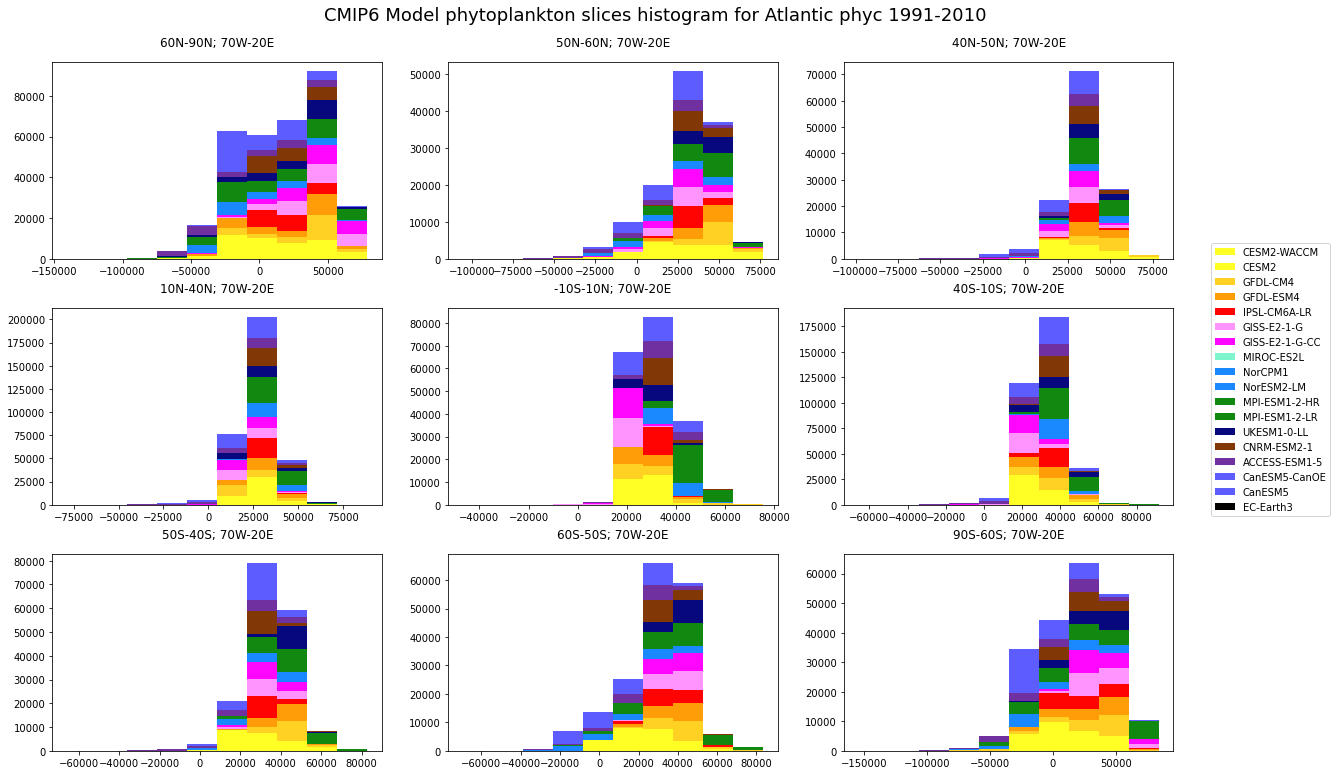

In [13]:
%%time

# plotting Atlantic


# var_names = ['phydiat']

for var in var_names:
    print(var)
    fig = plt.figure(figsize=(18, 11))
    ncol = 3
    nrow = 3
    i = 0
    for j in range(0,len(n_slice_high_list)):
        n_slice_low = n_slice_low_list[j]                            
        n_slice_high = n_slice_high_list[j]
        i = i + 1
        ax = plt.subplot(ncol,nrow,i)
        print(j)
        mi = 0
        hdata=[]
        for model in models:

#             if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
#                     plt.plot([], [], c=colors[mi], label=str(model), marker='o', markersize=7,  linewidth=2.0)
#                     mi = mi+1
#                     continue;
            ofn = '/home/jovyan/tempfolder/' + model + '_' + var + '_' + str(n_slice_low) + '_' + str(n_slice_high) + '_ln_histogram' + '_na.txt'

#             print(ofn)
            if os.path.exists(ofn):
    #             print(os.path.exists(ofn))    
                dm = []
                with open(ofn, "r") as rf:

                    for line in rf:
                        dm.append(float(line.strip()))

                xmon = np.arange(1, 13)
                s = np.array(dm)

             ## DONE in regridding
                if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                    if var == 'chl':
                        s = s * 0.001        # need more infromation, why???
                if var == 'phyc' or var=='phycos':
                    s = s * 12000 # 
                if var == 'phydiat' or var == 'phydiatos':
                    s = s * 12000 # 
                if var == 'zooc' or var == 'zoocos':
                    s = s * 12000 # 
                if var == 'intpp': 
                    s = s * 12000 #
                if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                    if var == 'intpp':
                        s = -s             # need more infromation
                    if var == 'fgco2':
                        s = s*(10**(-10))    # need more infromation
                    if var == 'dfe':
                        xmon =[]
                        s = []        # need more infromation
                hdata.append(s)
#                 plt.plot(xmon, s, c=colors[mi], label=str(model), marker='o', markersize=7, linewidth=2.0)
#                 print(mi)
    #             
            else:
                hdata.append([])
#                 plt.plot([], [], c=colors[mi], label=str(model), marker='o', markersize=7,  linewidth=2.0)
#                 print(mi)
    #             print('check6')
            mi = mi +1
    #         print(mi)
        #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
        #print(i)
#         plt.ylim(plot_ranges[i-1])
#         plt.xticks(np.arange(1, 13), Time_months)
#         ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
        plt.hist(hdata, stacked=True, color=colors)
        plt.title(plot_titles[i-1], fontsize=12, y=1.05)

    plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots
    fig.legend(models, loc='lower right', bbox_to_anchor=(1.025, 0.33)) 
    plt.suptitle('CMIP6 Model phytoplankton slices histogram for Atlantic ' + var + ' ' + str(start_year) + '-' + str(end_year), fontsize=18)
    #plt.savefig('/home/jovyan/quickplots/' + var +' Atlantic '+ str(start_year)+str(end_year)+'.png', dpi=600)

phyc
0
1
2
3
4
5
6
7
8
CPU times: user 3.78 s, sys: 76.2 ms, total: 3.85 s
Wall time: 3.85 s


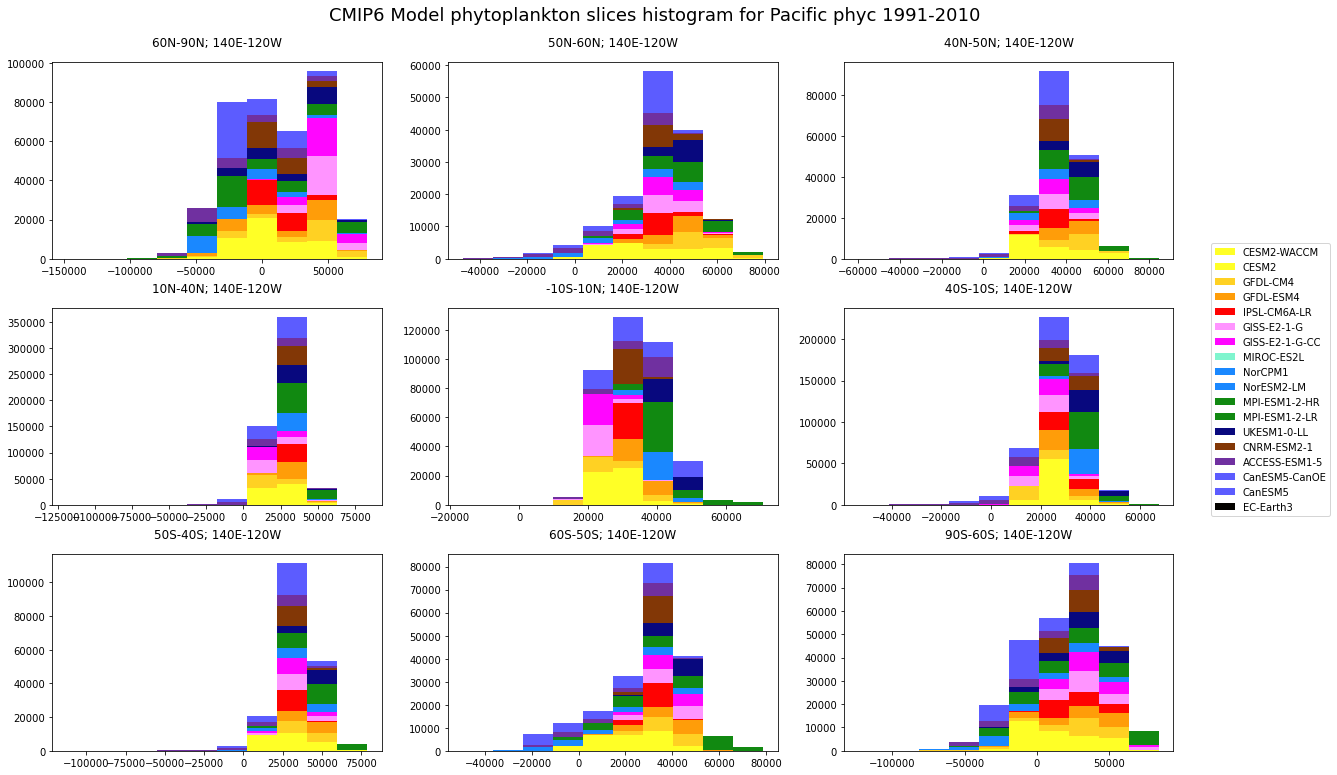

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [15]:
%%time

# plotting Pacific
plot_titles = ['60N-90N; 140E-120W','50N-60N; 140E-120W','40N-50N; 140E-120W','10N-40N; 140E-120W','-10S-10N; 140E-120W','40S-10S; 140E-120W','50S-40S; 140E-120W',
              '60S-50S; 140E-120W','90S-60S; 140E-120W']

# var_names = ['phydiat']

for var in var_names:
    print(var)
    fig = plt.figure(figsize=(18, 11))
    ncol = 3
    nrow = 3
    i = 0
    for j in range(0,len(n_slice_high_list)):
        n_slice_low = n_slice_low_list[j]                            
        n_slice_high = n_slice_high_list[j]
        i = i + 1
        ax = plt.subplot(ncol,nrow,i)
        print(j)
        mi = 0
        hdata=[]
        for model in models:

#             if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
#                     plt.plot([], [], c=colors[mi], label=str(model), marker='o', markersize=7,  linewidth=2.0)
#                     mi = mi+1
#                     continue;
            ofn = '/home/jovyan/tempfolder/' + model + '_' + var + '_' + str(n_slice_low) + '_' + str(n_slice_high) + '_ln_histogram' + '_np.txt'

#             print(ofn)
            if os.path.exists(ofn):
    #             print(os.path.exists(ofn))    
                dm = []
                with open(ofn, "r") as rf:

                    for line in rf:
                        dm.append(float(line.strip()))

                xmon = np.arange(1, 13)
                s = np.array(dm)

             ## DONE in regridding
                if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                    if var == 'chl':
                        s = s * 0.001        # need more infromation, why???
                if var == 'phyc' or var=='phycos':
                    s = s * 12000 # 
                if var == 'phydiat' or var == 'phydiatos':
                    s = s * 12000 # 
                if var == 'zooc' or var == 'zoocos':
                    s = s * 12000 # 
                if var == 'intpp': 
                    s = s * 12000 #
                if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                    if var == 'intpp':
                        s = -s             # need more infromation
                    if var == 'fgco2':
                        s = s*(10**(-10))    # need more infromation
                    if var == 'dfe':
                        xmon =[]
                        s = []        # need more infromation
                hdata.append(s)
#                 plt.plot(xmon, s, c=colors[mi], label=str(model), marker='o', markersize=7, linewidth=2.0)
#                 print(mi)
    #             
            else:
                hdata.append([])
#                 plt.plot([], [], c=colors[mi], label=str(model), marker='o', markersize=7,  linewidth=2.0)
#                 print(mi)
    #             print('check6')
            mi = mi +1
    #         print(mi)
        #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
        #print(i)
#         plt.ylim(plot_ranges[i-1])
#         plt.xticks(np.arange(1, 13), Time_months)
#         ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
        plt.hist(hdata, stacked=True, color=colors)
        plt.title(plot_titles[i-1], fontsize=12, y=1.05)

    plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots
    fig.legend(models, loc='lower right', bbox_to_anchor=(1.025, 0.33)) 
    plt.suptitle('CMIP6 Model phytoplankton slices histogram for Pacific ' + var + ' ' + str(start_year) + '-' + str(end_year), fontsize=18)
    #plt.savefig('/home/jovyan/quickplots/' + var +' Atlantic '+ str(start_year)+str(end_year)+'.png', dpi=600)